In [1]:
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim

### Reading Data

In [2]:
def load_tiff_images(folder):
    files = sorted(glob.glob(os.path.join(folder, "*.tif")))
    imgs, names = [], []
    for f in files:
        imgs.append(tifffile.imread(f))
        names.append(os.path.splitext(os.path.basename(f))[0])
    return np.array(imgs), names

def load_png_labels(folder):
    files = sorted(glob.glob(os.path.join(folder, "*.png")))
    labels, names = [], []
    for f in files:
        im = Image.open(f).convert("L")
        arr = np.array(im)
        labels.append((arr > 0).astype(np.uint8))
        names.append(os.path.splitext(os.path.basename(f))[0])
    return np.array(labels), names

def align_by_name(X, X_names, y, y_names):
    common = sorted(set(X_names) & set(y_names))
    if not common:
        m = min(len(X), len(y))
        return X[:m], y[:m], X_names[:m], y_names[:m]
    idx_x = [X_names.index(n) for n in common]
    idx_y = [y_names.index(n) for n in common]
    return X[idx_x], y[idx_y], common, common

X, X_names = load_tiff_images("E:/D/Cellula/Task2/week3/data/images")
y, y_names = load_png_labels("E:/D/Cellula/Task2/week3/data/labels")

X, y, _, _ = align_by_name(X, X_names, y, y_names)

In [3]:
# Normalize X
# Convert to float32 and scale each channel to [0, 1]
X = X.astype(np.float32)
X = X / X.max()  

#Ensure y is binary
y = (y > 0).astype(np.uint8)  # 1 for water, 0 for background

In [4]:
# Convert to PyTorch tensors
X = np.transpose(X, (0, 3, 1, 2))
X_tensor = torch.from_numpy(X)

y_tensor = torch.from_numpy(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

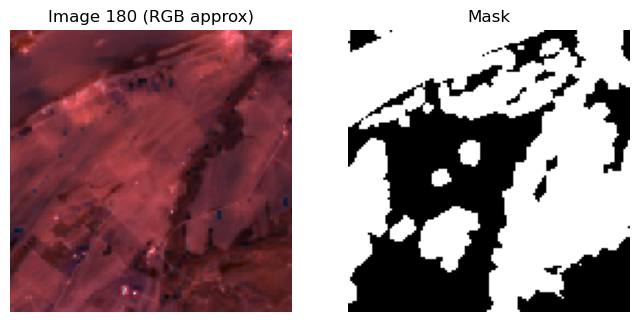

In [26]:
import random
def visualize_image_label(X_tensor, y_tensor, idx):
    # Get image and label
    img = X_tensor[idx].cpu().numpy()  # shape: [C, H, W]
    img = np.transpose(img, (1, 2, 0))  # shape: [H, W, C]
    
    # Approximate RGB using first 3 channels
    rgb = img[:, :, :3]
    # Normalize each channel for display
    for c in range(3):
        channel = rgb[:, :, c]
        rgb[:, :, c] = (channel - channel.min()) / (channel.max() - channel.min() + 1e-6)
    
    # Get label
    label = y_tensor[idx].cpu().numpy()
    if label.ndim == 3 and label.shape[0] == 1:  # if shape [1,H,W]
        label = label[0]

    # Plot
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    plt.title(f"Image {idx} (RGB approx)")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap="gray")
    plt.title("Mask")
    plt.axis("off")
    
    plt.show()
    
visualize_image_label(X_train, y_train, idx=random.randint(0, X_train.shape[0]-1))

In [6]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Training batches: {len(train_loader)}, Testing batches: {len(test_loader)}")

Training batches: 16, Testing batches: 4


### Build the model, and evaluation metrices 

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model 
model = smp.Unet(
    encoder_name="resnet34",        # pretrained encoder
    encoder_weights="imagenet",     # use ImageNet weights
    in_channels=12,                 # 12-channel input
    classes=1,                      # binary mask
).to(device)

In [8]:
def dice_coef(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
# Train the model
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_dice = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device).float()  # ensure float
        y_batch = y_batch.to(device, dtype=torch.float32)
        if y_batch.ndim == 3:
            y_batch = y_batch.unsqueeze(1)    # add channel dim

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coef(y_pred, y_batch).item()

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Dice: {train_dice:.4f}")

Epoch 1/100 | Loss: 0.3873 | Dice: 0.7142
Epoch 2/100 | Loss: 0.3033 | Dice: 0.7546
Epoch 3/100 | Loss: 0.2957 | Dice: 0.7631
Epoch 4/100 | Loss: 0.2808 | Dice: 0.7738
Epoch 5/100 | Loss: 0.2977 | Dice: 0.7643
Epoch 6/100 | Loss: 0.2784 | Dice: 0.7787
Epoch 7/100 | Loss: 0.2783 | Dice: 0.7803
Epoch 8/100 | Loss: 0.2526 | Dice: 0.7982
Epoch 9/100 | Loss: 0.2406 | Dice: 0.7778
Epoch 10/100 | Loss: 0.2473 | Dice: 0.7906
Epoch 11/100 | Loss: 0.2737 | Dice: 0.7779
Epoch 12/100 | Loss: 0.2535 | Dice: 0.8007
Epoch 13/100 | Loss: 0.2555 | Dice: 0.7991
Epoch 14/100 | Loss: 0.2368 | Dice: 0.8017
Epoch 15/100 | Loss: 0.2454 | Dice: 0.7986
Epoch 16/100 | Loss: 0.2282 | Dice: 0.8141
Epoch 17/100 | Loss: 0.2903 | Dice: 0.7368
Epoch 18/100 | Loss: 0.2490 | Dice: 0.8006
Epoch 19/100 | Loss: 0.2142 | Dice: 0.8347
Epoch 20/100 | Loss: 0.2108 | Dice: 0.8250
Epoch 21/100 | Loss: 0.2076 | Dice: 0.8289
Epoch 22/100 | Loss: 0.2095 | Dice: 0.8116
Epoch 23/100 | Loss: 0.2139 | Dice: 0.8084
Epoch 24/100 | Loss:

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device, dtype=torch.float32)
        if y_batch.ndim == 3:
            y_batch = y_batch.unsqueeze(1)

        y_pred = model(X_batch)
        y_pred = torch.sigmoid(y_pred)
        y_pred = (y_pred > 0.5).float()  # threshold to binary

        # Flatten to compute metrics per pixel
        all_preds.append(y_pred.cpu().numpy().flatten())
        all_targets.append(y_batch.cpu().numpy().flatten())

# Concatenate all batches
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Compute metrics for water class
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)
iou = jaccard_score(all_targets, all_preds)

print(f"Validation metrics for water class:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")

Validation metrics for water class:
Precision: 0.9491
Recall:    0.8868
F1-score:  0.9169
IoU:       0.8465


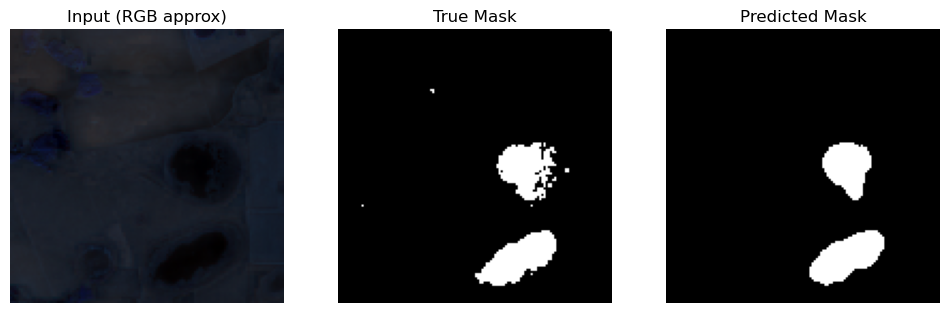

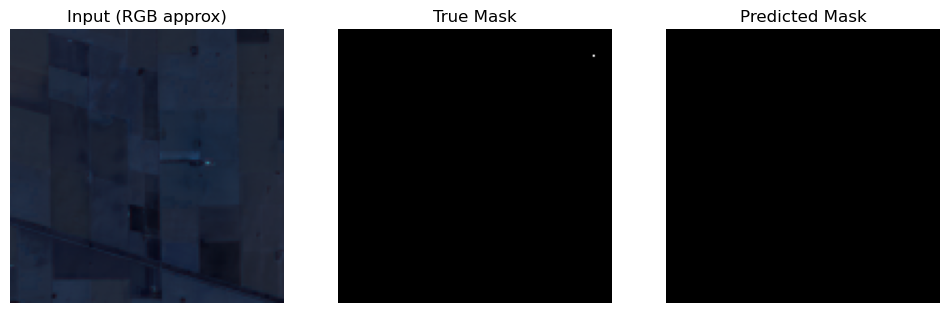

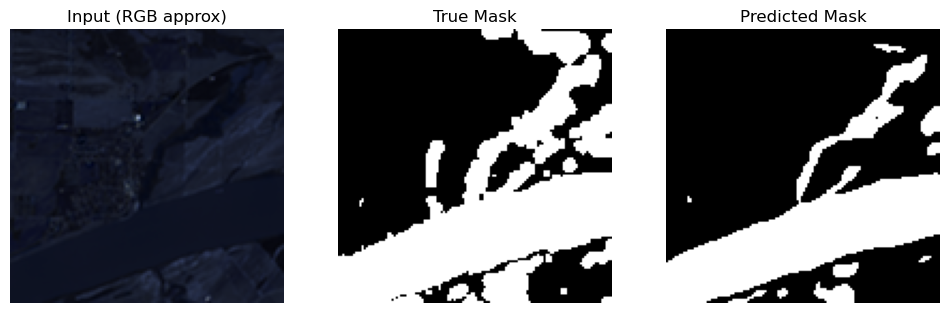

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Directories
image_dir = "E:/D/Cellula/Task2/week3/data/images"
mask_dir  = "E:/D/Cellula/Task2/week3/data/labels"

# Get all filenames
image_files = sorted(os.listdir(image_dir))
mask_files  = sorted(os.listdir(mask_dir))

# Randomly pick 3 images without replacement
random_indices = np.random.choice(len(image_files), size=3, replace=False)
image_files = [image_files[i] for i in random_indices]
mask_files  = [mask_files[i]  for i in random_indices]

model.eval()
with torch.no_grad():
    for img_file, mask_file in zip(image_files, mask_files):
        # Load image (12-channel TIFF)
        img = tifffile.imread(os.path.join(image_dir, img_file)).astype(np.float32)
        img /= img.max()  # normalize to [0,1]
        X_input = torch.from_numpy(np.transpose(img, (2, 0, 1))).unsqueeze(0).to(device).float()  # [1,12,H,W]

        # Load mask (binary PNG)
        mask = np.array(Image.open(os.path.join(mask_dir, mask_file)).convert("L"))
        mask = (mask > 0).astype(np.uint8)

        # Predict
        y_pred = model(X_input)
        y_pred = torch.sigmoid(y_pred)
        y_pred = (y_pred > 0.5).float().cpu().numpy().squeeze()

        # Plot
        plt.figure(figsize=(12, 4))

        # Input (first 3 channels as RGB approximation)
        plt.subplot(1, 3, 1)
        rgb_image = img[:, :, :3]           # shape: (H, W, 3)
        rgb_image = np.clip(rgb_image, 0, 1)
        plt.imshow(rgb_image)
        plt.title("Input (RGB approx)")
        plt.axis("off")

        # True mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(y_pred, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

In [27]:
# Save the fine-tuned model
model_path = "water_segmentation_unet_resnet34.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to water_segmentation_unet_resnet34.pth
